In [1]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np
import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import label_ranking_average_precision_score

# Get the dataset


In [2]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


# Split the dataset


In [3]:
from sklearn.model_selection import train_test_split

N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset

GALLERY_SIZE = [2,5,8]

def split(N_IDENTITIES, GALLERY_SIZE, validation_size=0.15):
    gallery_indices = []
    probe_indices = []

    for i in range(N_IDENTITIES):
        indices = list(np.where(faces.target == i)[0])
        np.random.shuffle(indices)  # Shuffle the indices for each identity
        gallery_indices += indices[:GALLERY_SIZE]
        probe_indices += indices[GALLERY_SIZE:]

    x_train = faces.images[gallery_indices]
    y_train = faces.target[gallery_indices]

    x_test = faces.images[probe_indices]
    y_test = faces.target[probe_indices]

    # Shuffle the training set before splitting into train and validation
    train_indices = np.arange(len(x_train))
    np.random.shuffle(train_indices)
    x_train = x_train[train_indices]
    y_train = y_train[train_indices]

    x_val = x_train[:int(validation_size * len(x_train))]
    y_val = y_train[:int(validation_size * len(y_train))]
    x_train = x_train[int(validation_size * len(x_train)):]
    y_train = y_train[int(validation_size * len(y_train)):]

    x_train = np.expand_dims(x_train, 3)

    return x_train, y_train, x_test, y_test, x_val, y_val


# Data Augmentation

This augmentation is suitable for the task although it does not improve much the accuracy.

Looking at the images, we see the faces are rotated a bit, or shifted a bit. No face is rotated by 90 or 180 degree so horizontal_flip should not be used.


In [4]:
augmentation = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    horizontal_flip=False
)

In [5]:
def plot_cmc_curve(y_true, y_score):

    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=y_score.shape[1])

    lraps = label_ranking_average_precision_score(y_true_one_hot, y_score)

    # Rank predictions
    ranks = np.argsort(-y_score, axis=1)

    # Calculate CMC
    matches = (ranks == y_true[:, None])

    cmc_scores = np.cumsum(matches, axis=1) / (np.arange(matches.shape[1]) + 1)
    cmc_scores = np.mean(cmc_scores, axis=0)

    # Plot CMC curve
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(cmc_scores) + 1), cmc_scores, marker='o')
    plt.title('CMC Curve')
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.grid(True)
    plt.show()

    return cmc_scores

# y_score = model.predict(x_test)

# cmc_scores = plot_cmc_curve(y_test, y_score)


In [6]:
def create_LeNet_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=120, activation='relu'))
  model.add(tf.keras.layers.Dense(units=84, activation='relu'))
  model.add(tf.keras.layers.Dense(units=40, activation = 'softmax'))

  print(model.summary())
  return model

In [7]:
def training_model(x_train, y_train, x_test, y_test, x_val, y_val, model):
  learning_rate = 0.001
  loss_function = 'sparse_categorical_crossentropy'
  batch_size = 32
  num_epochs = 100
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
  model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

  #train
  steps_for_epoch = np.ceil(x_train.shape[0] / batch_size)
  # history = model.fit(augmentation.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch = steps_for_epoch, epochs=num_epochs, validation_data=(x_val, y_val), workers=4, callbacks=[early_stop, model_save])
  history = model.fit(x=x_train,y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stop, model_save])


  plt.rcParams["figure.figsize"] = (20,10)

  # accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  # loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  # restore weights from the best training point
  model.load_weights('best_model.h5')

  scores = model.evaluate(x_train, y_train, verbose=0)
  print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  scores = model.evaluate(x_val, y_val, verbose=0)
  print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  scores = model.evaluate(x_test, y_test, verbose=0)
  print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  cm = confusion_matrix(y_test, y_pred_classes)

  # Plot the confusion matrix
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

  cmc_scores = plot_cmc_curve(y_test, y_pred)

In [8]:
def training_model_with_augmentation(x_train, y_train, x_test, y_test, x_val, y_val, augmentation, model):
  learning_rate = 0.001
  loss_function = 'sparse_categorical_crossentropy'
  batch_size = 32
  num_epochs = 100
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
  model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

  #train
  steps_for_epoch = np.ceil(x_train.shape[0] / batch_size)
  history = model.fit(x=x_train,y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stop, model_save])


  plt.rcParams["figure.figsize"] = (20,10)

  # accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  # loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  # restore weights from the best training point
  model.load_weights('best_model.h5')

  scores = model.evaluate(x_train, y_train, verbose=0)
  print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  scores = model.evaluate(x_val, y_val, verbose=0)
  print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  scores = model.evaluate(x_test, y_test, verbose=0)
  print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  cm = confusion_matrix(y_test, y_pred_classes)

  # Plot the confusion matrix
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

  cmc_scores = plot_cmc_curve(y_test, y_pred)

# Run the experiments

Here is the code I used to get the results below!


### Scenario 1


In [9]:
x_train, y_train, x_test, y_test, x_val, y_val = split(N_IDENTITIES, 2)

In [10]:
model = create_LeNet_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 120)               3

Epoch 1/100
3/3 [==============================] - 19s 519ms/step - loss: 3.7258 - accuracy: 0.0588 - val_loss: 3.8935 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 3.6863 - accuracy: 0.0294 - val_loss: 3.8640 - val_accuracy: 0.0000e+00
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 3.6755 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 32ms/step - loss: 3.6679 - accuracy: 0.0294 - val_loss: 3.8388 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 35ms/step - loss: 3.6566 - accuracy: 0.0294 - val_loss: 3.8707 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 3.6438 - accuracy: 0.0294 - val_loss: 3.8756 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 34ms/step - loss: 3.6373 - accuracy: 0.0588 - val_loss: 3.8241 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 3.6222 - accuracy: 0.1176 - val_loss: 3.8143 - val_accuracy: 0.0000e+00
Epoch 8/100
3/3 [==============================] - 0s 26ms/step - loss: 3.6060 - accuracy: 0.1176 - val_loss: 3.8428 - val_accuracy: 0.0000e+00
Epoch 9/100
3/3 [==============================] - 0s 28ms/step - loss: 3.5933 - accuracy: 0.0882 - val_loss: 3.8886 - val_accuracy: 0.0000e+00
Epoc

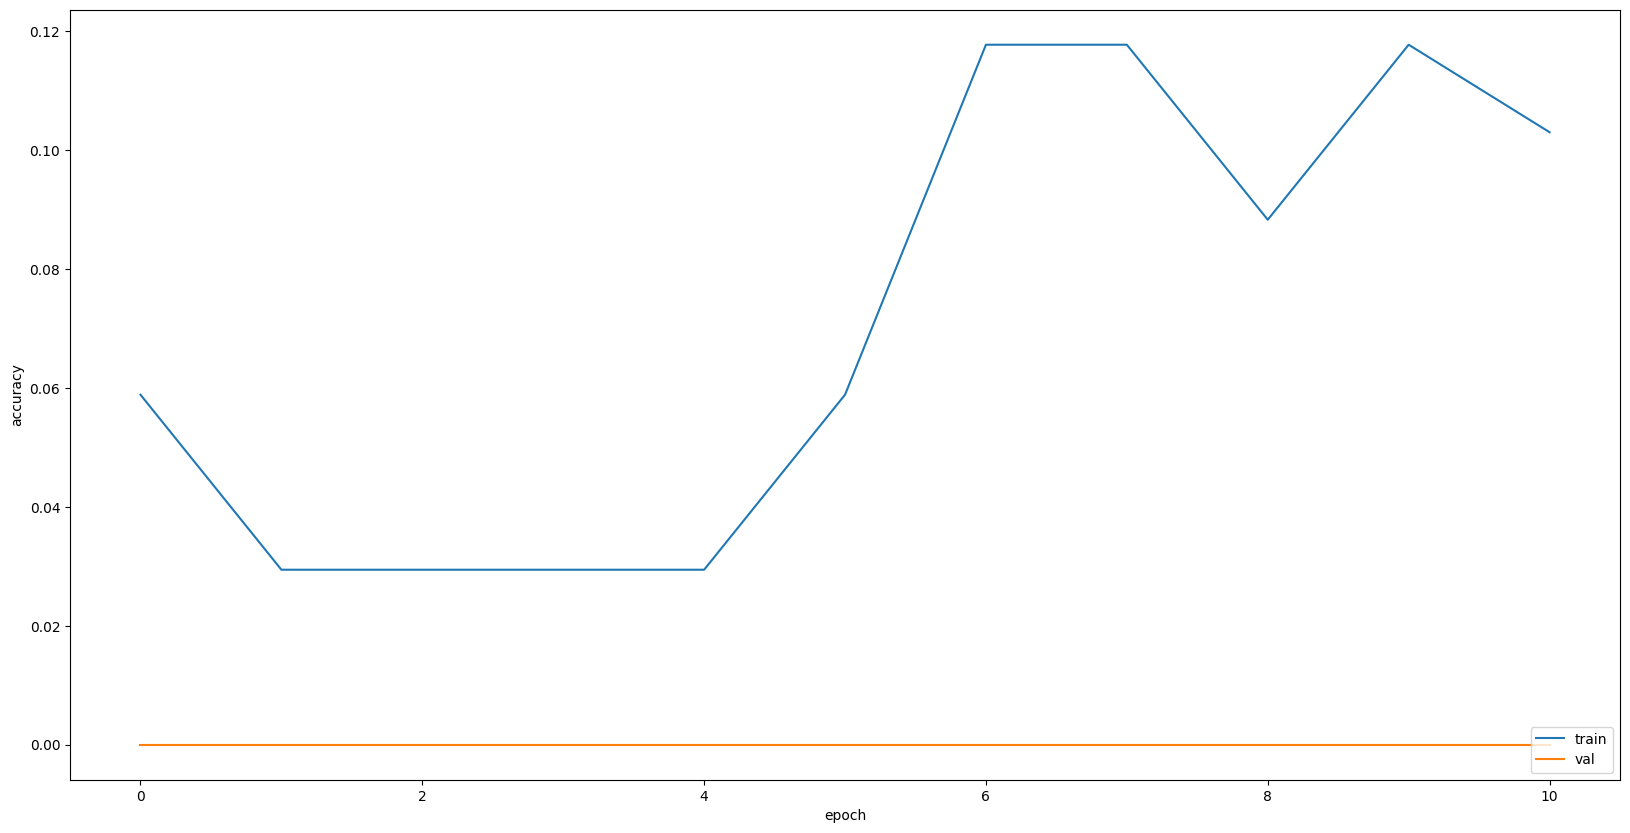

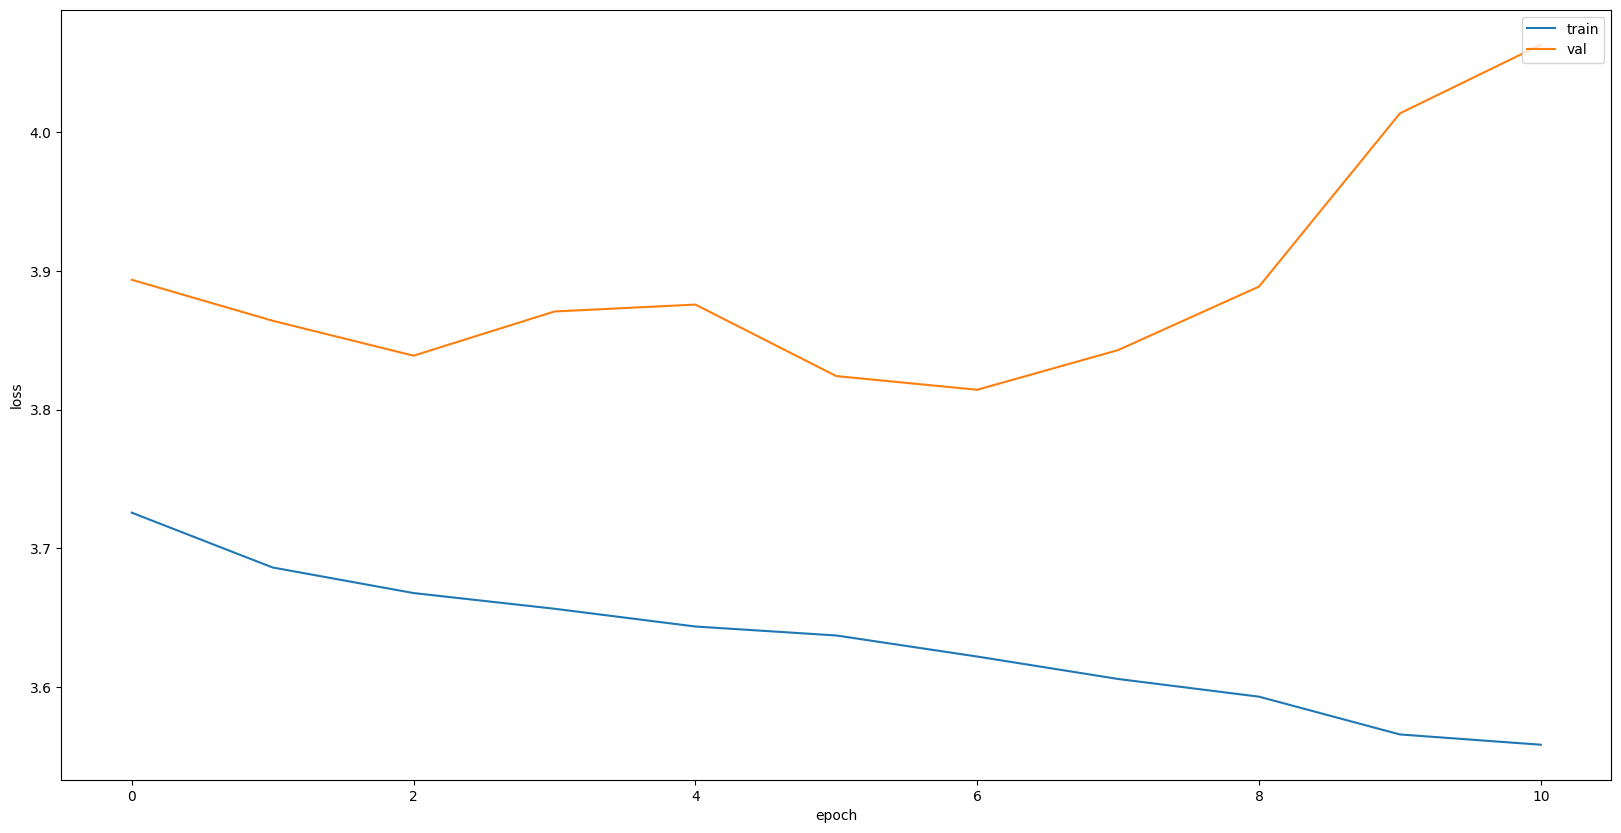

TRAINING SET
Loss: 3.6714212894439697 
Accuracy: 0.029411764815449715

VALIDATION SET
Loss: 3.893498659133911 
Accuracy: 0.0

TEST SET
Loss: 3.709920883178711 
Accuracy: 0.02500000037252903
10/10 [==============================] - 0s 5ms/step


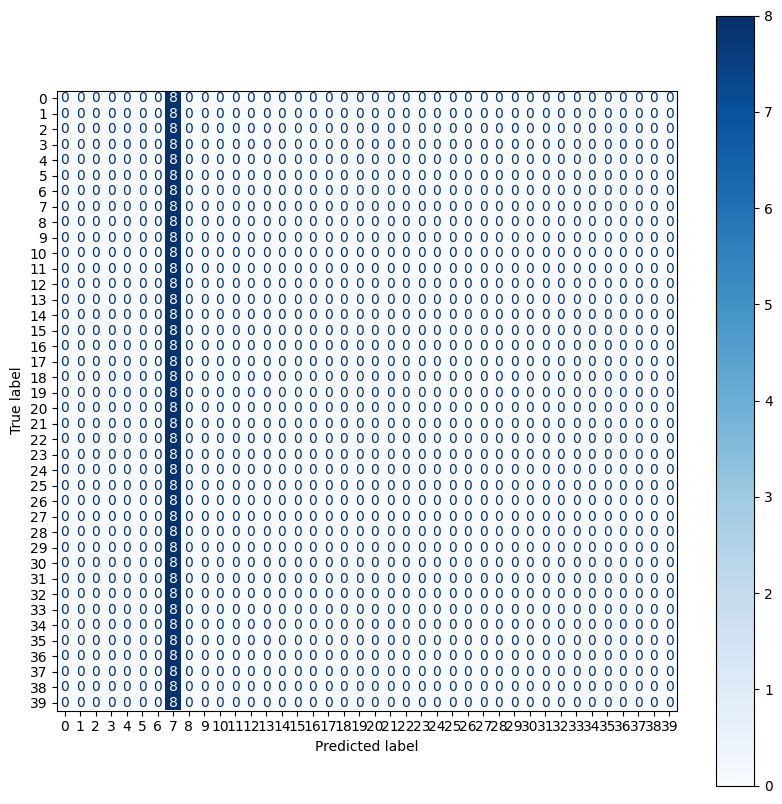

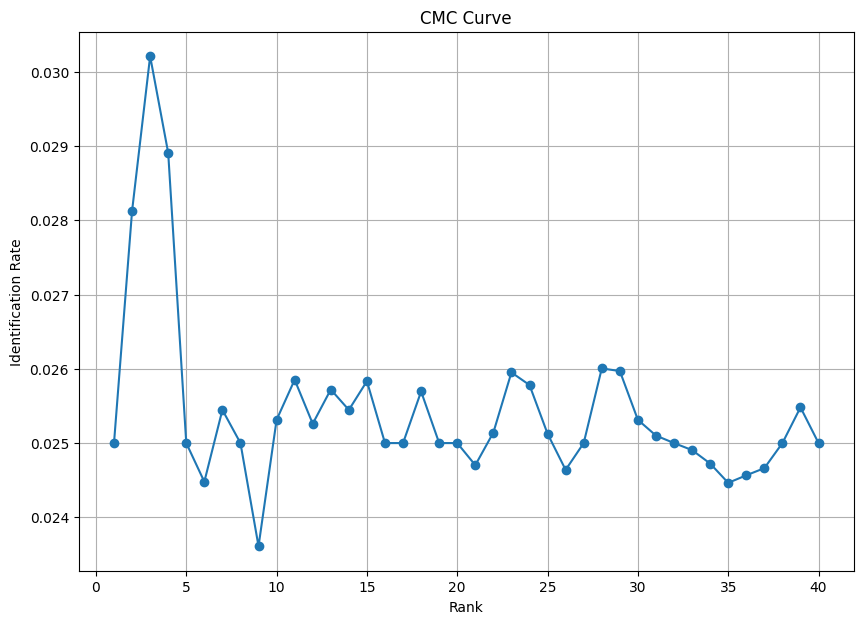

In [11]:
training_model(x_train, y_train, x_test, y_test, x_val, y_val, model)

Epoch 1/100
3/3 [==============================] - 2s 117ms/step - loss: 3.7111 - accuracy: 0.0147 - val_loss: 3.8532 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 3.6549 - accuracy: 0.0588 - val_loss: 3.8148 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 3.6454 - accuracy: 0.0294 - val_loss: 3.8723 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 3.6323 - accuracy: 0.0294 - val_loss: 3.9660 - val_accuracy: 0.0000e+00
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 3.6158 - accuracy: 0.0312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 18ms/step - loss: 3.6155 - accuracy: 0.0294 - val_loss: 3.9780 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 3.5929 - accuracy: 0.1176 - val_loss: 4.0453 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 3.5882 - accuracy: 0.0588 - val_loss: 4.0723 - val_accuracy: 0.0000e+00
Epoch 8/100
3/3 [==============================] - 0s 25ms/step - loss: 3.5500 - accuracy: 0.1324 - val_loss: 3.9935 - val_accuracy: 0.0000e+00
Epoch 9/100
3/3 [==============================] - 0s 28ms/step - loss: 3.5199 - accuracy: 0.1471 - val_loss: 3.9337 - val_accuracy: 0.0000e+00
Epoch 10/100
3/3 [==============================] - 0s 34ms/step - loss: 3.4846 - accuracy: 0.1176 - val_loss: 4.0301 - val_accuracy: 0.0000e+00
Epoch 11/100
3/3 [==============================] - 0s 32ms/step - loss: 3.4530 - accuracy: 0.0588 - val_loss: 4.0846 - val_accuracy: 0.0000e+00
Ep

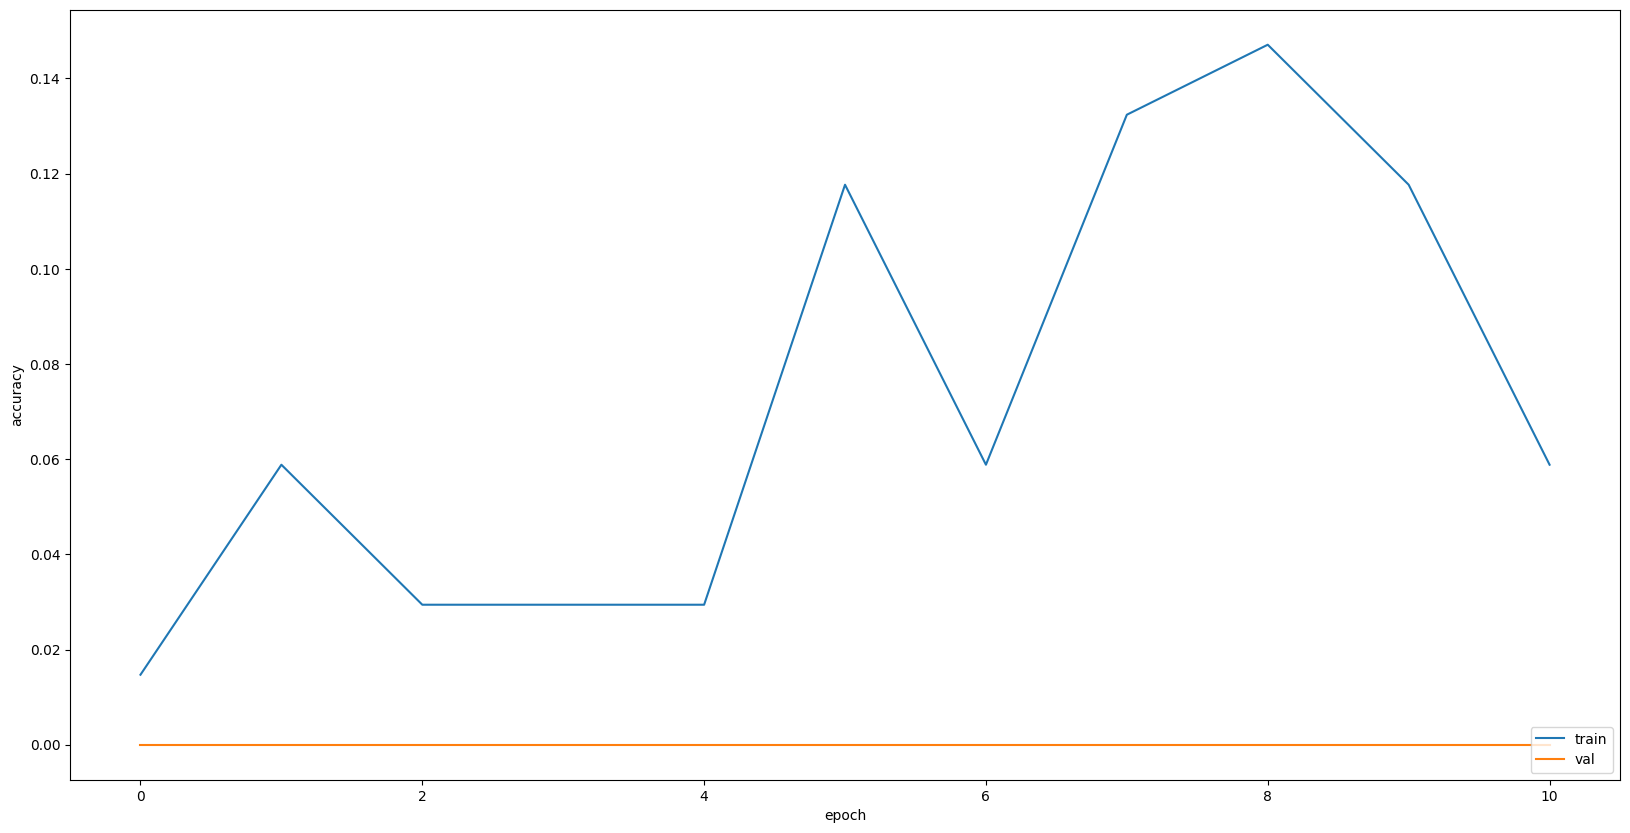

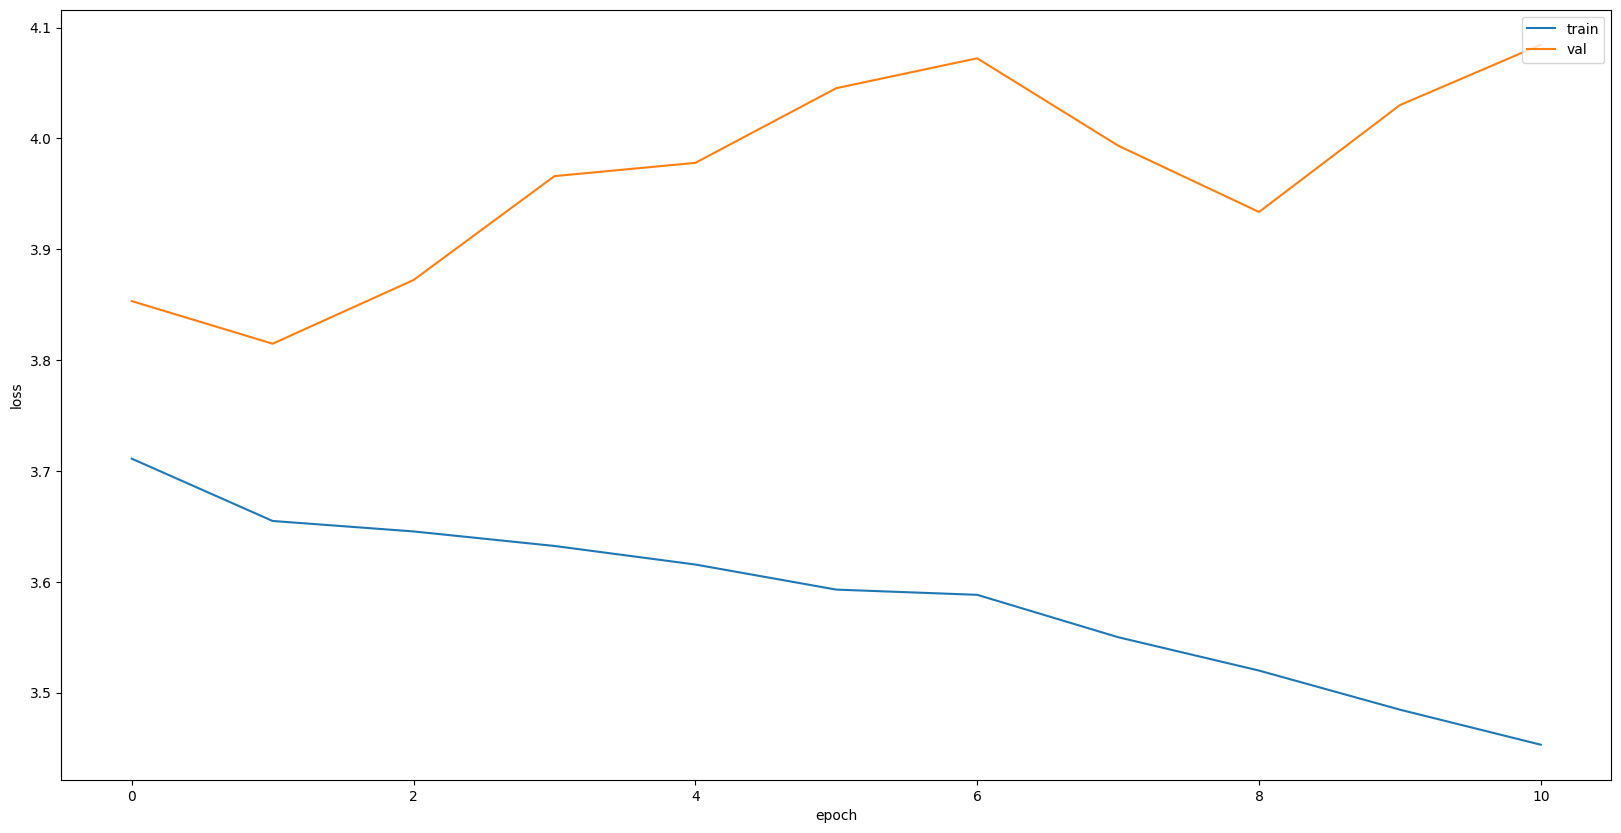

TRAINING SET
Loss: 3.6449694633483887 
Accuracy: 0.05882352963089943

VALIDATION SET
Loss: 3.853226900100708 
Accuracy: 0.0

TEST SET
Loss: 3.6871674060821533 
Accuracy: 0.03125
10/10 [==============================] - 0s 4ms/step


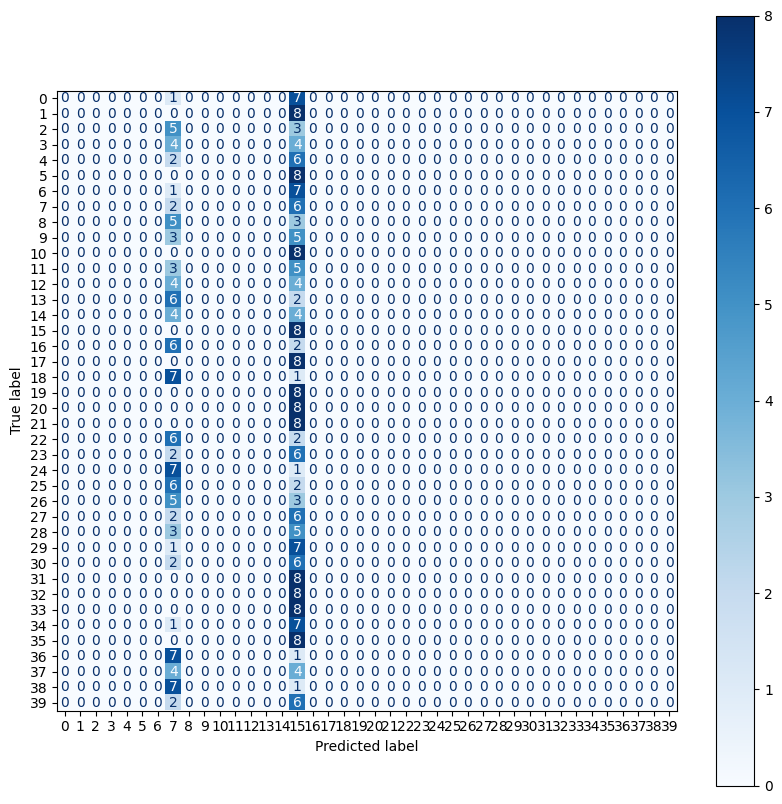

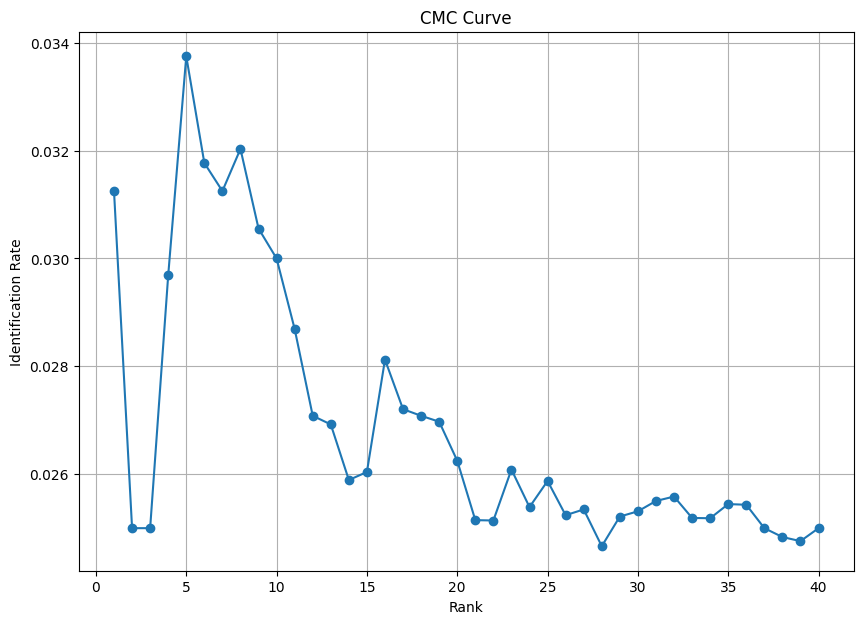

In [12]:
# training with augmentation
training_model_with_augmentation(x_train, y_train, x_test, y_test, x_val, y_val, augmentation, model)

### Scenario 2


In [13]:
x_train, y_train, x_test, y_test, x_val, y_val = split(N_IDENTITIES, 5)

In [14]:
model = create_LeNet_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2704)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

Epoch 1/100
6/6 [==============================] - 2s 76ms/step - loss: 3.7315 - accuracy: 0.0000e+00 - val_loss: 3.6971 - val_accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 3.6877 - accuracy: 0.0235 - val_loss: 3.6902 - val_accuracy: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 3.6855 - accuracy: 0.0294 - val_loss: 3.6917 - val_accuracy: 0.0000e+00
Epoch 4/100
1/6 [====>.........................] - ETA: 0s - loss: 3.6868 - accuracy: 0.0312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 10ms/step - loss: 3.6788 - accuracy: 0.0294 - val_loss: 3.6944 - val_accuracy: 0.0000e+00
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 3.6690 - accuracy: 0.0471 - val_loss: 3.6944 - val_accuracy: 0.0000e+00
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 3.6499 - accuracy: 0.0706 - val_loss: 3.6966 - val_accuracy: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 3.6177 - accuracy: 0.0824 - val_loss: 3.7100 - val_accuracy: 0.0000e+00
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 3.5736 - accuracy: 0.0824 - val_loss: 3.7220 - val_accuracy: 0.0000e+00
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 3.4984 - accuracy: 0.1059 - val_loss: 3.7125 - val_accuracy: 0.0000e+00
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 3.4013 - accuracy: 0.1353 - val_loss: 3.6960 - val_accuracy: 0.0000e+00
Epoc

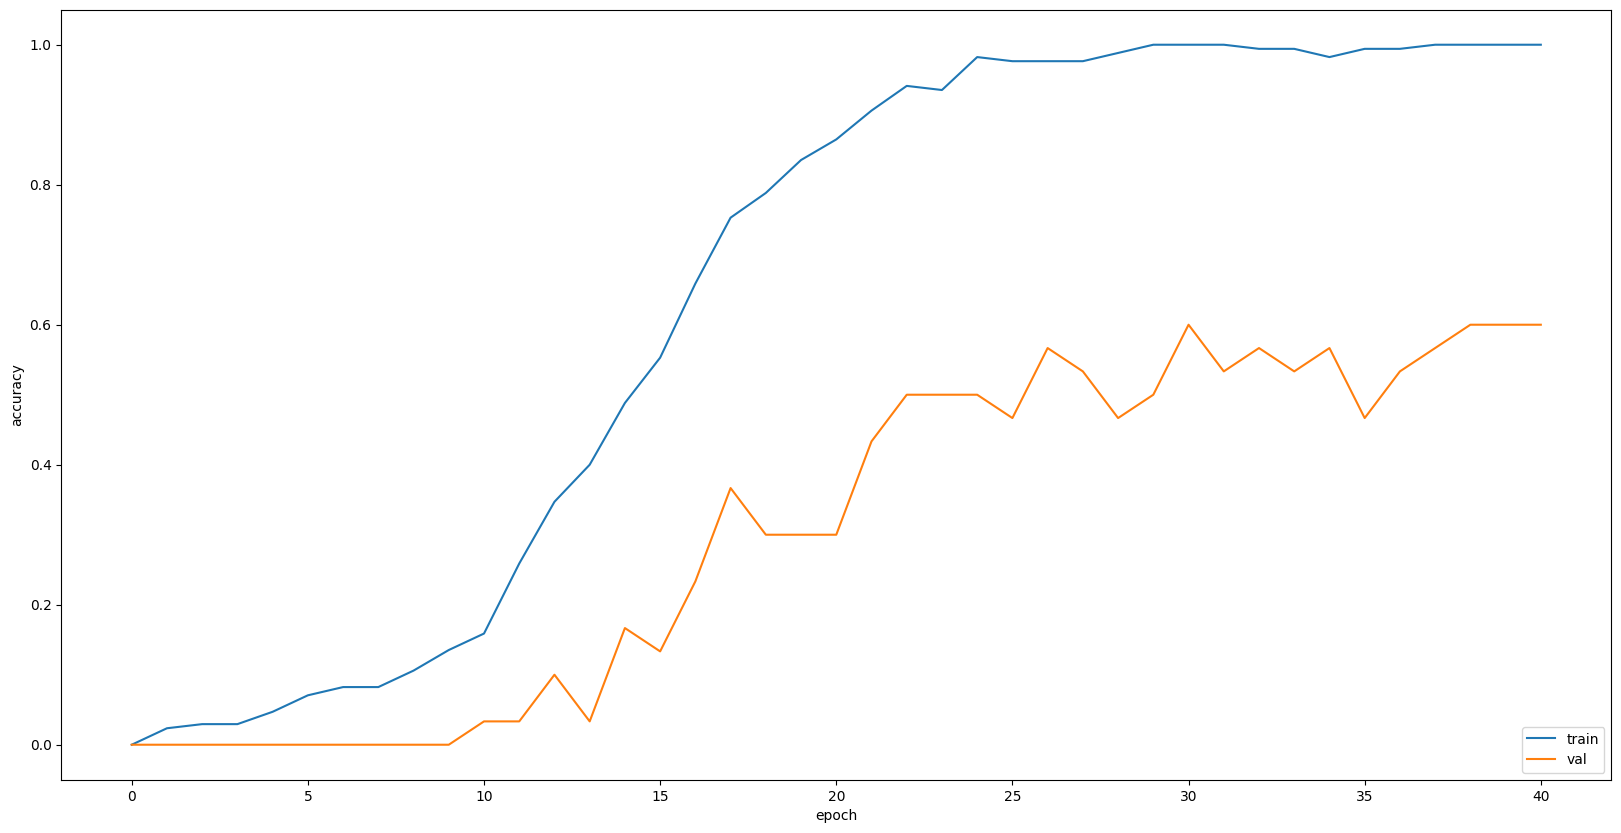

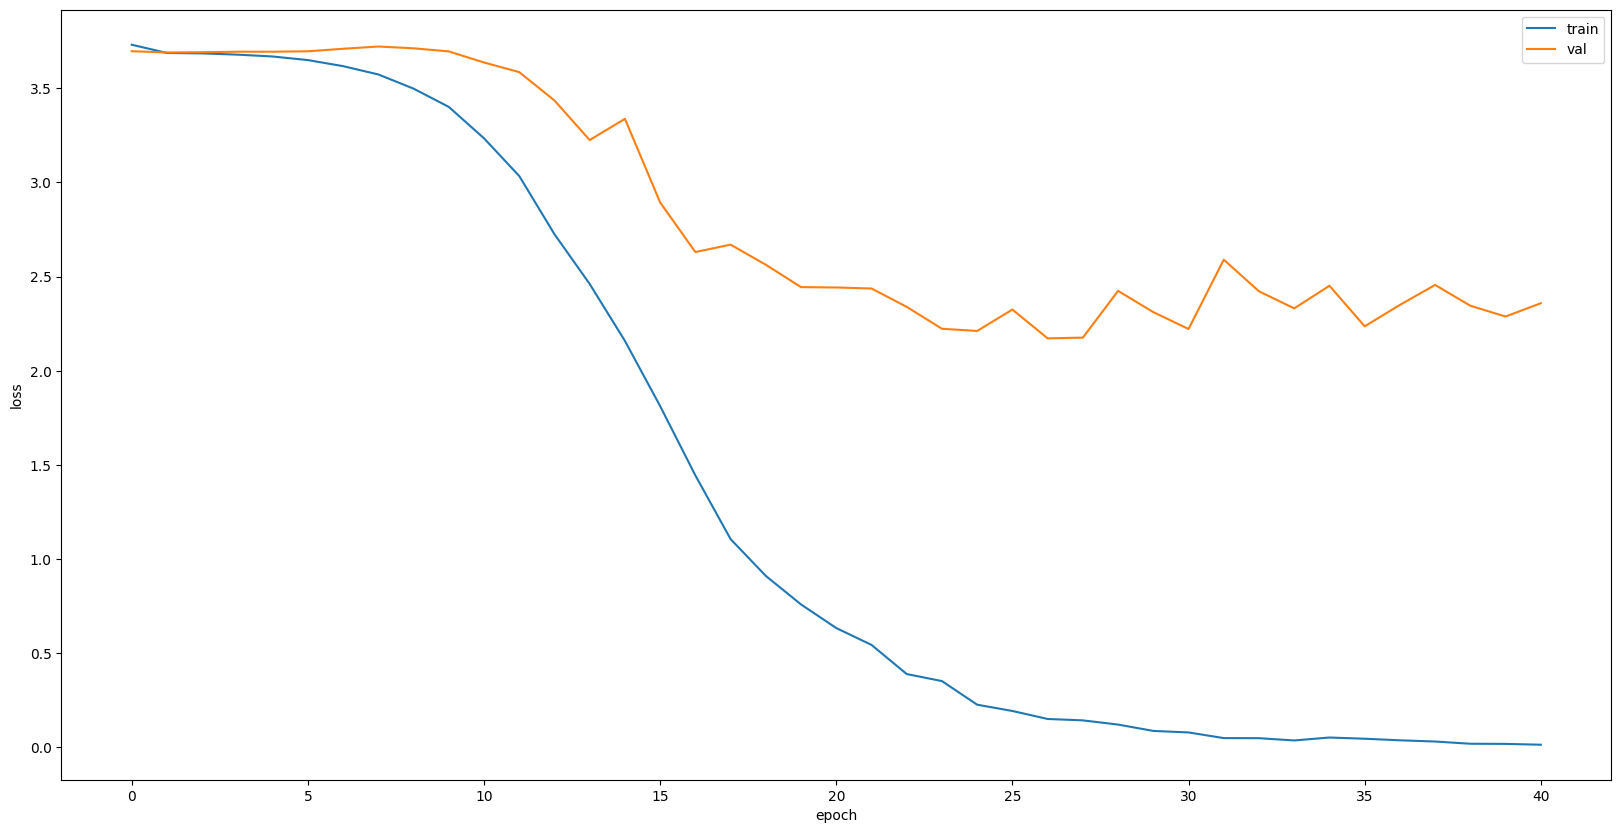

TRAINING SET
Loss: 0.048656828701496124 
Accuracy: 1.0

VALIDATION SET
Loss: 2.2219722270965576 
Accuracy: 0.6000000238418579

TEST SET
Loss: 1.1285151243209839 
Accuracy: 0.7699999809265137
7/7 [==============================] - 0s 3ms/step


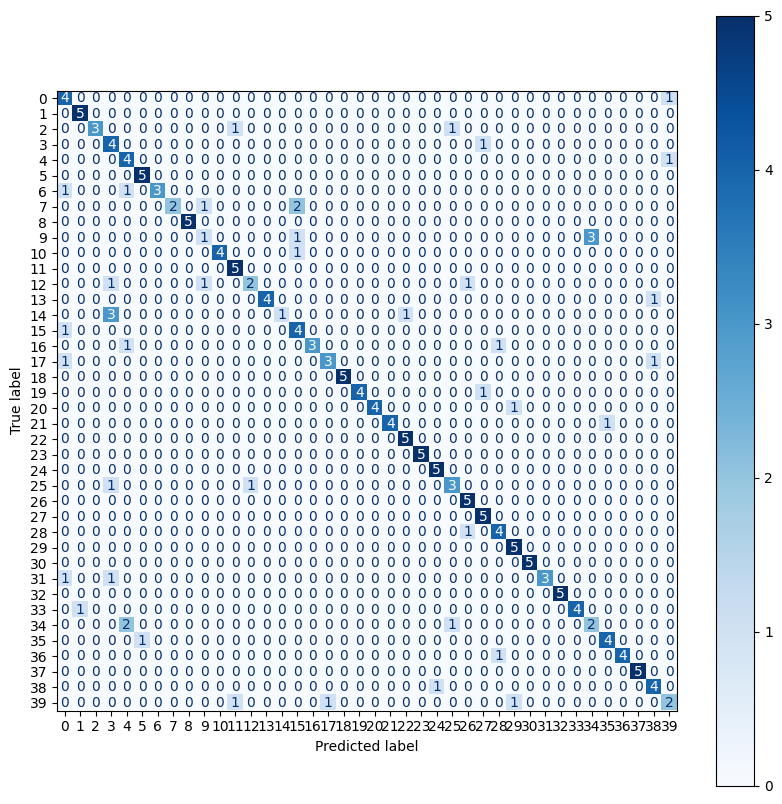

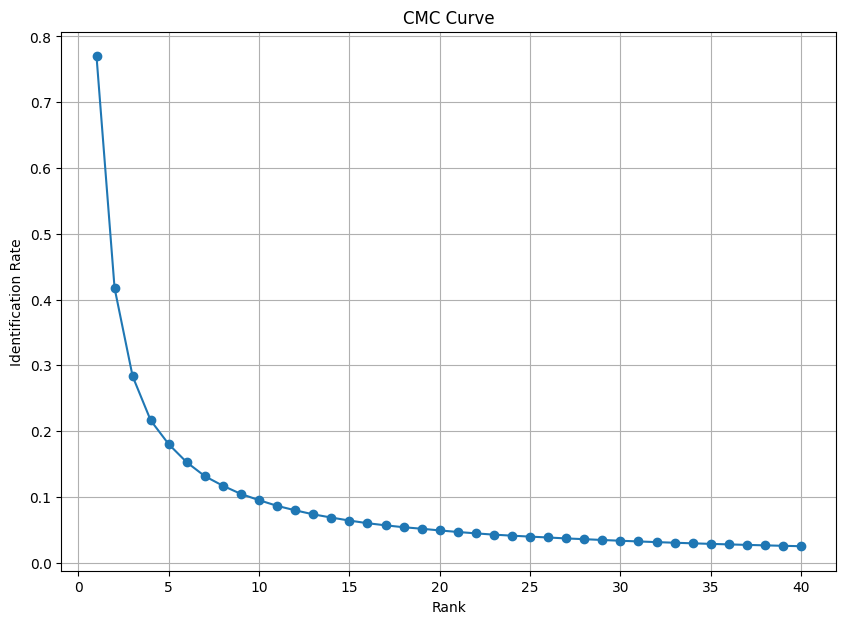

In [15]:
training_model(x_train, y_train, x_test, y_test, x_val, y_val, model)

Epoch 1/100
6/6 [==============================] - 3s 91ms/step - loss: 0.2121 - accuracy: 0.9471 - val_loss: 2.2954 - val_accuracy: 0.4667
Epoch 2/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1470 - accuracy: 0.9765 - val_loss: 2.5041 - val_accuracy: 0.5000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0852 - accuracy: 0.9882 - val_loss: 2.3145 - val_accuracy: 0.6333
Epoch 4/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0640 - accuracy: 0.9941 - val_loss: 2.1973 - val_accuracy: 0.5667
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0743 - accuracy: 0.9882 - val_loss: 2.5148 - val_accuracy: 0.5333
Epoch 6/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0511 - accuracy: 0.9941 - val_loss: 2.4845 - val_accuracy: 0.5000
Epoch 7/100
6/6 [==============================] - 0s 38ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 2.2185 - val_accuracy: 0.5667
Epoch 8/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 2.1041 - val_accuracy: 0.5333
Epoch 9/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 2.1784 - val_accuracy: 0.5333
Epoch 10/100
6/6 [==

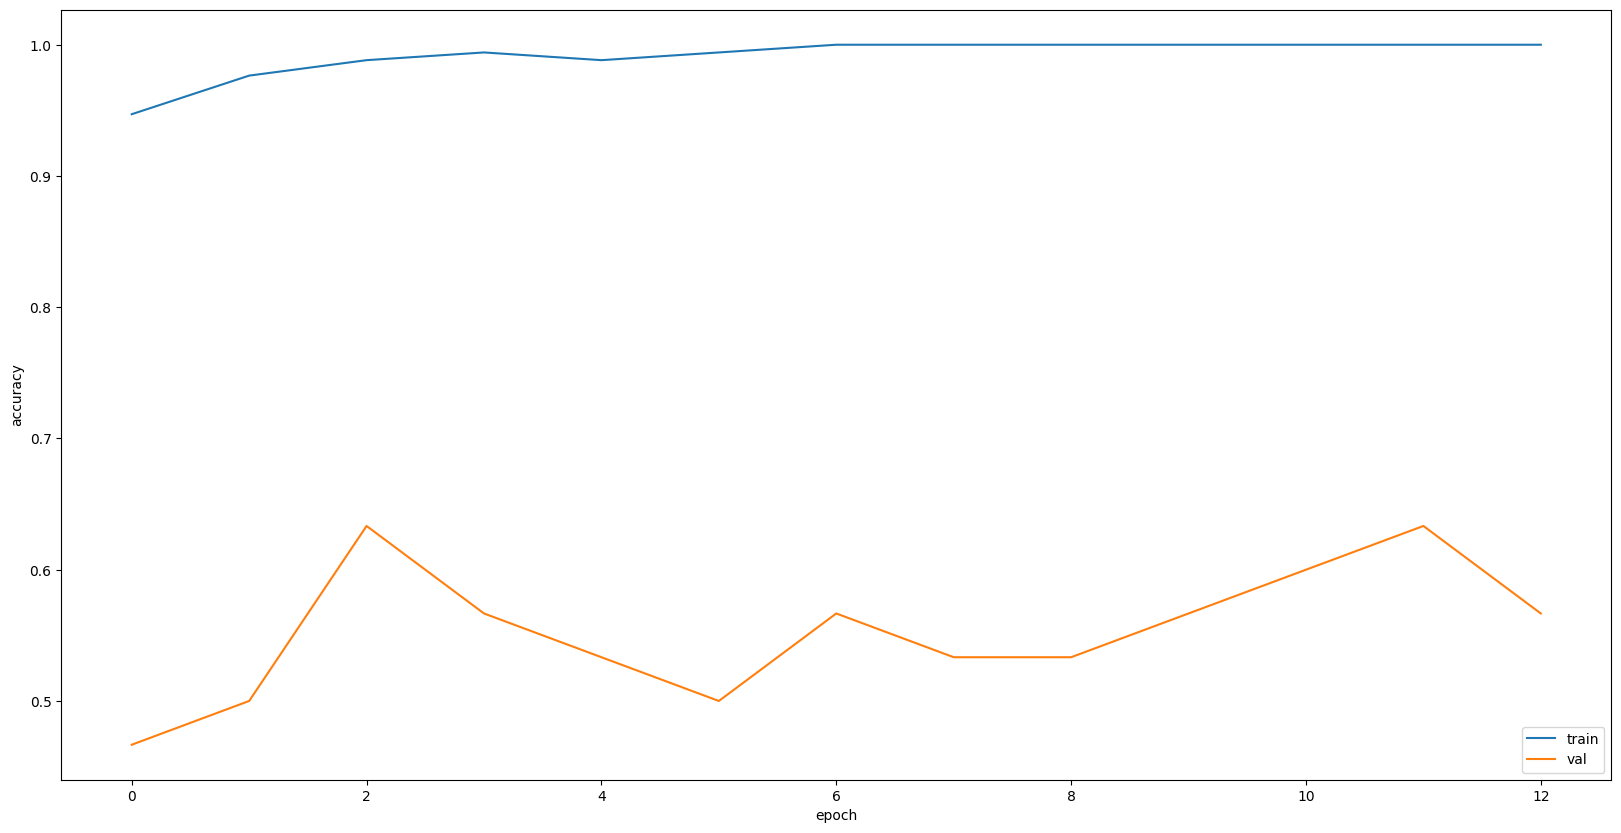

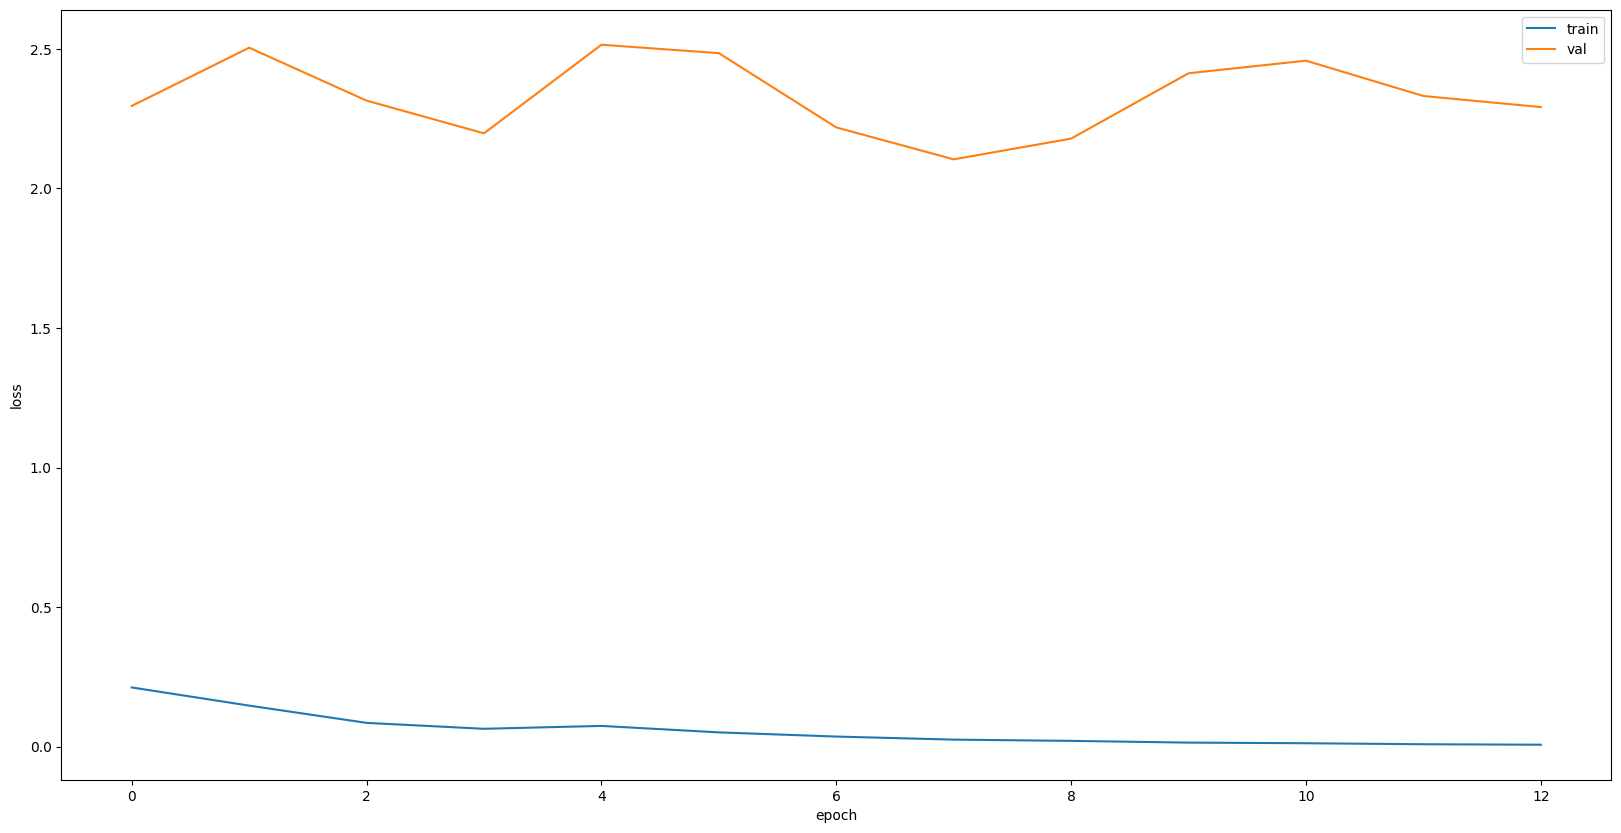

TRAINING SET
Loss: 0.06652896106243134 
Accuracy: 0.9882352948188782

VALIDATION SET
Loss: 2.314500093460083 
Accuracy: 0.6333333253860474

TEST SET
Loss: 1.2737137079238892 
Accuracy: 0.7300000190734863
7/7 [==============================] - 0s 3ms/step


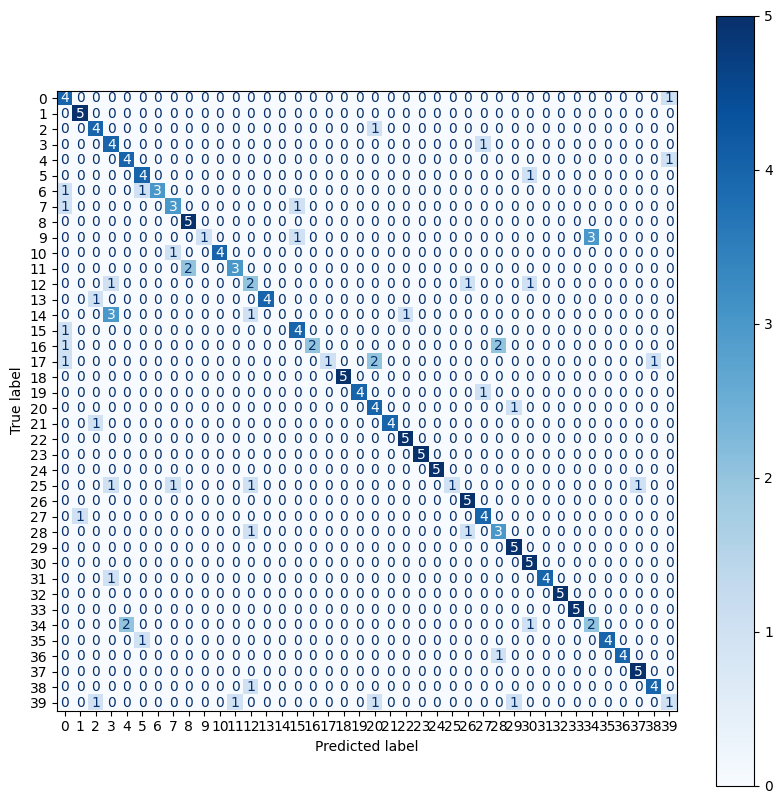

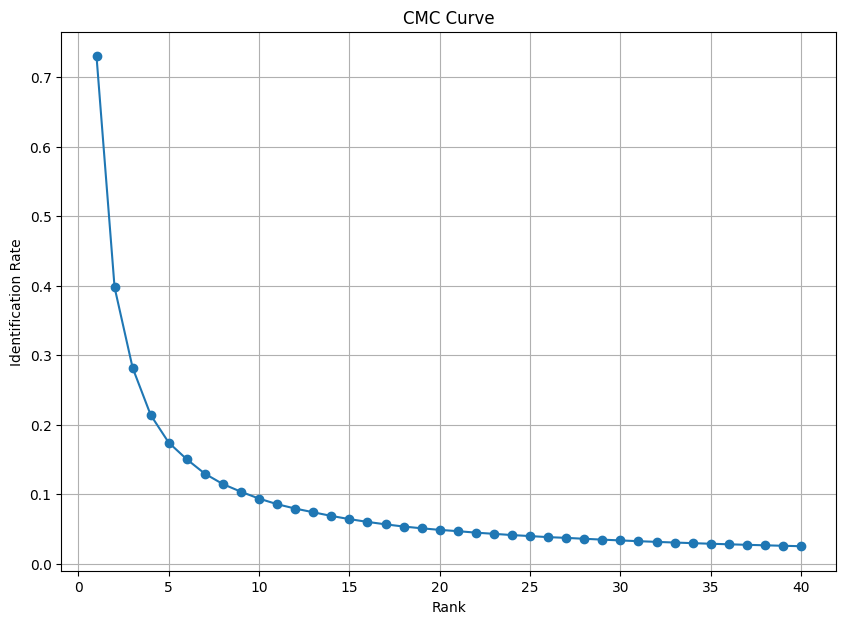

In [16]:
# training with augmentation
training_model_with_augmentation(x_train, y_train, x_test, y_test, x_val, y_val, augmentation, model)

### Scenario 3


In [17]:
x_train, y_train, x_test, y_test, x_val, y_val = split(N_IDENTITIES, 8)

In [18]:
model = create_LeNet_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2704)              0         
                                                                 
 dense_6 (Dense)             (None, 120)              

Epoch 1/100
9/9 [==============================] - 2s 43ms/step - loss: 3.6990 - accuracy: 0.0221 - val_loss: 3.7165 - val_accuracy: 0.0208
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 3.6736 - accuracy: 0.0404 - val_loss: 3.6964 - val_accuracy: 0.0000e+00
Epoch 3/100
1/9 [==>...........................] - ETA: 0s - loss: 3.6455 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 10ms/step - loss: 3.6488 - accuracy: 0.0551 - val_loss: 3.7134 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 3.6030 - accuracy: 0.0662 - val_loss: 3.6970 - val_accuracy: 0.0417
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 3.4844 - accuracy: 0.1066 - val_loss: 3.5970 - val_accuracy: 0.0208
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 3.3160 - accuracy: 0.1250 - val_loss: 3.5540 - val_accuracy: 0.1042
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 3.0153 - accuracy: 0.2647 - val_loss: 3.3468 - val_accuracy: 0.1875
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 2.6166 - accuracy: 0.3456 - val_loss: 2.9935 - val_accuracy: 0.2292
Epoch 9/100
9/9 [==============================] - 0s 15ms/step - loss: 2.1342 - accuracy: 0.5037 - val_loss: 2.7267 - val_accuracy: 0.3542
Epoch 10/100
9/9 [===========

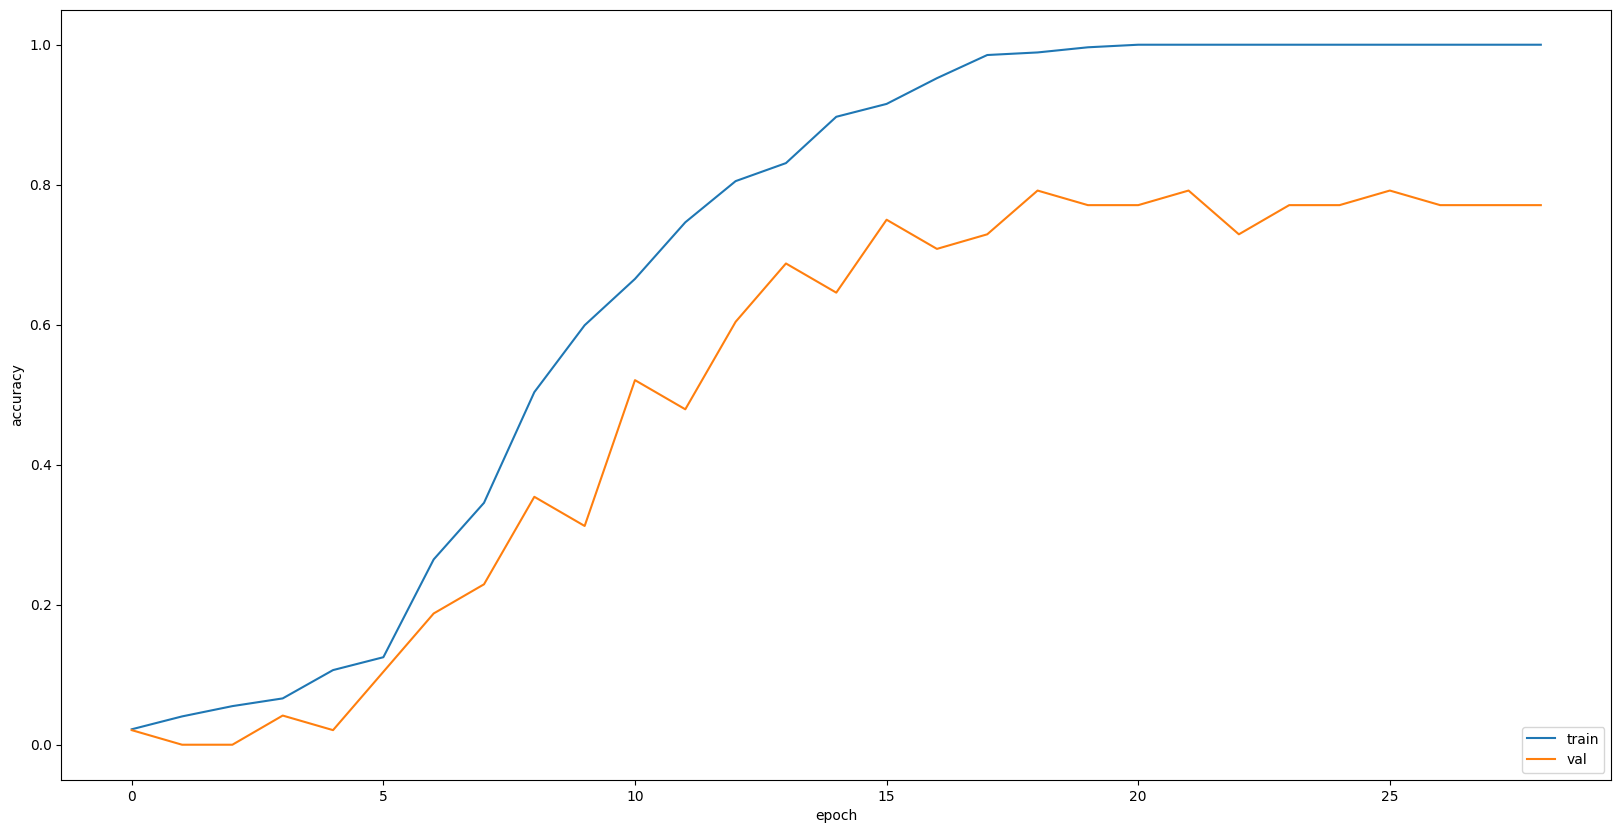

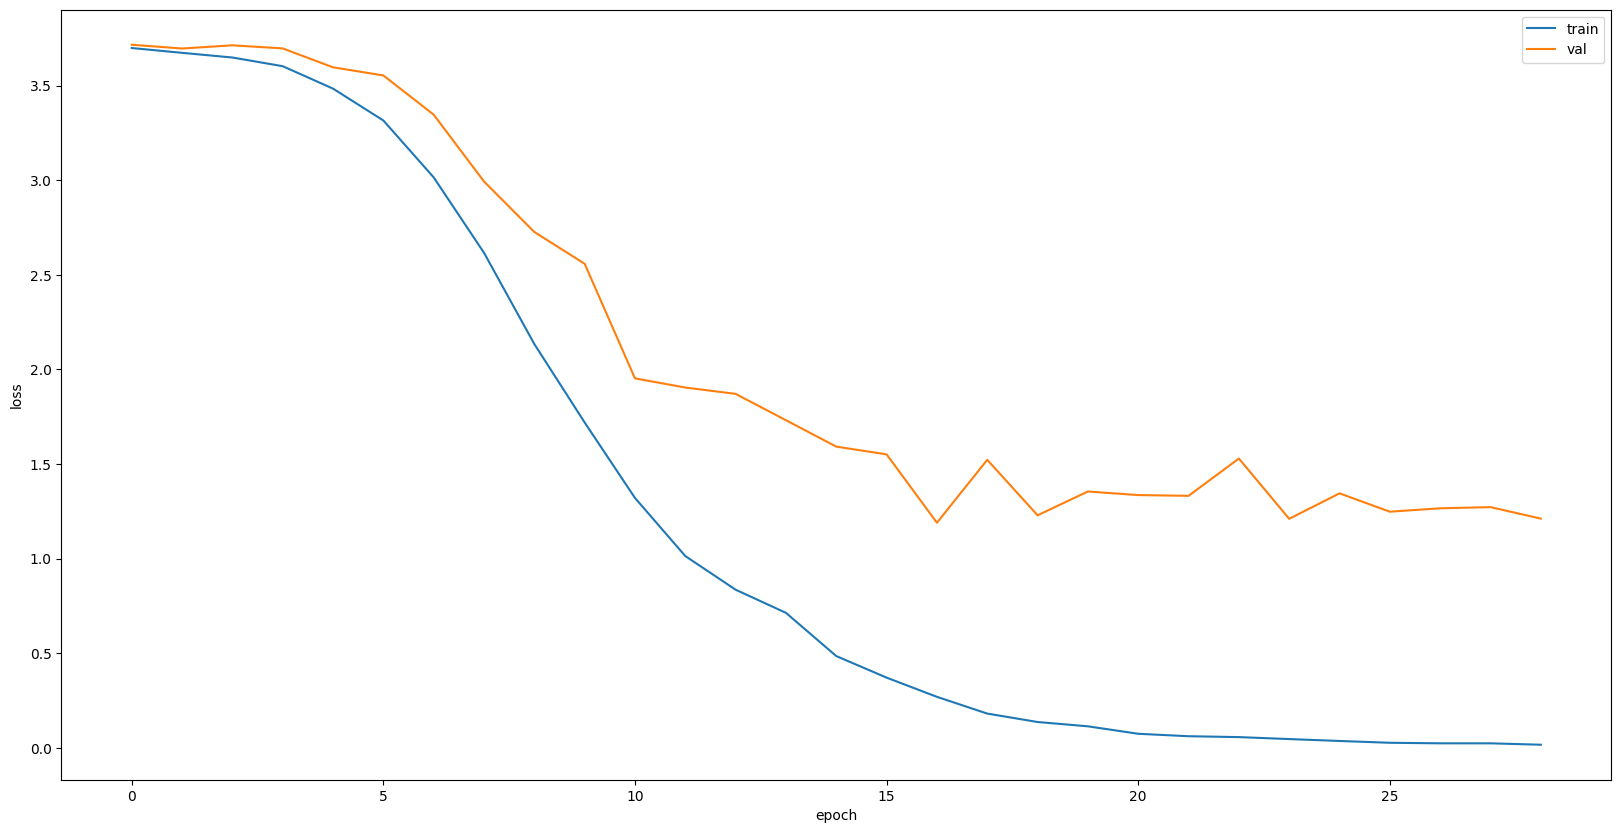

TRAINING SET
Loss: 0.09714630991220474 
Accuracy: 0.9963235259056091

VALIDATION SET
Loss: 1.228985071182251 
Accuracy: 0.7916666865348816

TEST SET
Loss: 0.44346538186073303 
Accuracy: 0.875
3/3 [==============================] - 0s 4ms/step


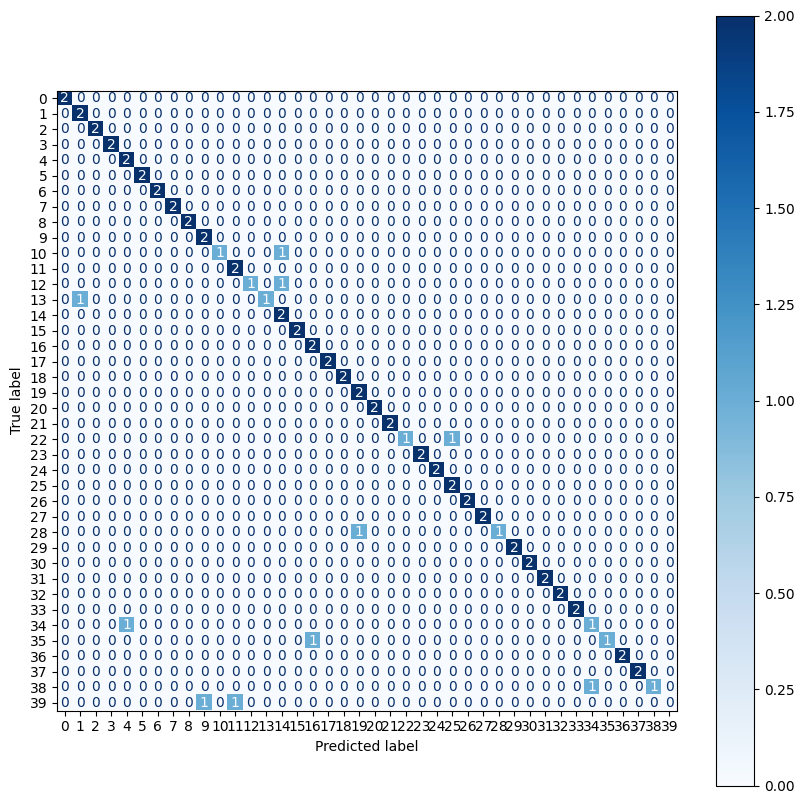

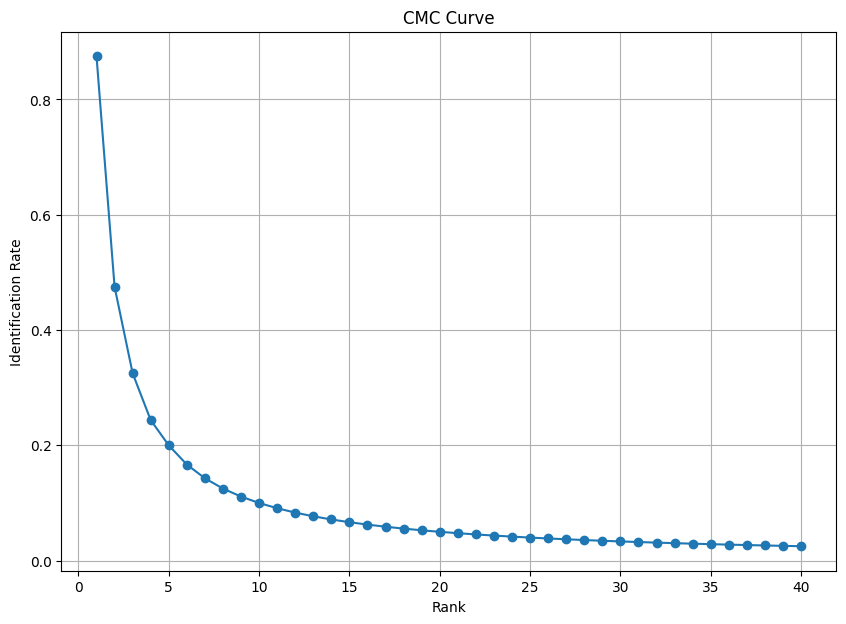

In [19]:
training_model(x_train, y_train, x_test, y_test, x_val, y_val, model)

Epoch 1/100
9/9 [==============================] - 2s 33ms/step - loss: 0.3322 - accuracy: 0.9044 - val_loss: 1.2141 - val_accuracy: 0.7500
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.2293 - accuracy: 0.9522 - val_loss: 1.5950 - val_accuracy: 0.7708
Epoch 3/100
1/9 [==>...........................] - ETA: 0s - loss: 0.1390 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 10ms/step - loss: 0.1469 - accuracy: 0.9963 - val_loss: 1.2750 - val_accuracy: 0.7708
Epoch 4/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0882 - accuracy: 0.9963 - val_loss: 1.3168 - val_accuracy: 0.7292
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0673 - accuracy: 0.9926 - val_loss: 1.4509 - val_accuracy: 0.7083
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0448 - accuracy: 0.9963 - val_loss: 1.3316 - val_accuracy: 0.7708
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 1.2366 - val_accuracy: 0.7708
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 1.2229 - val_accuracy: 0.7917
Epoch 9/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 1.3619 - val_accuracy: 0.7500
Epoch 10/100
9/9 [=================

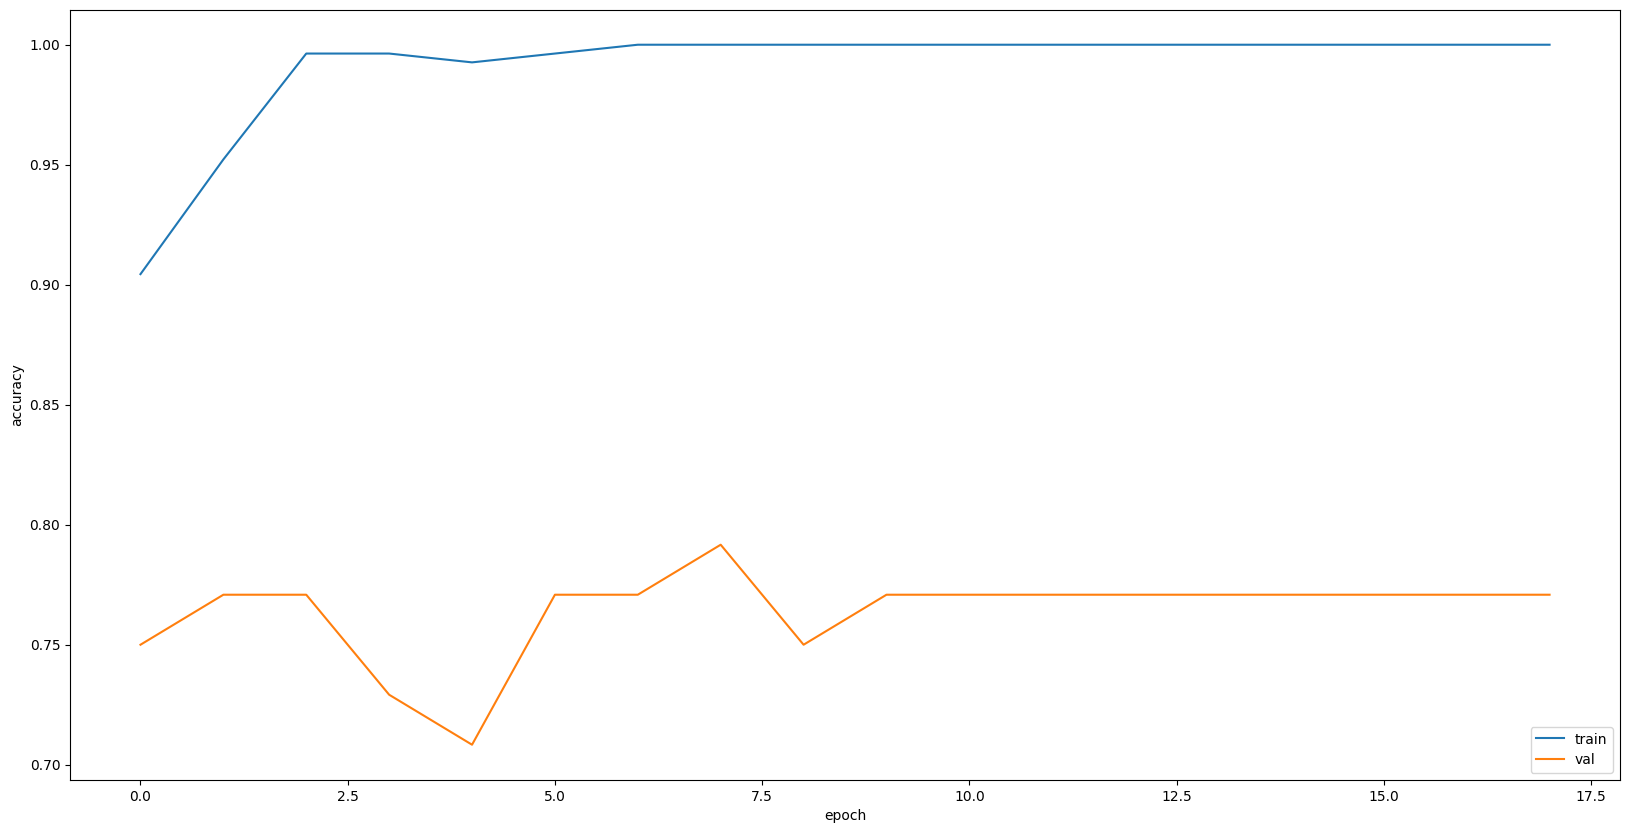

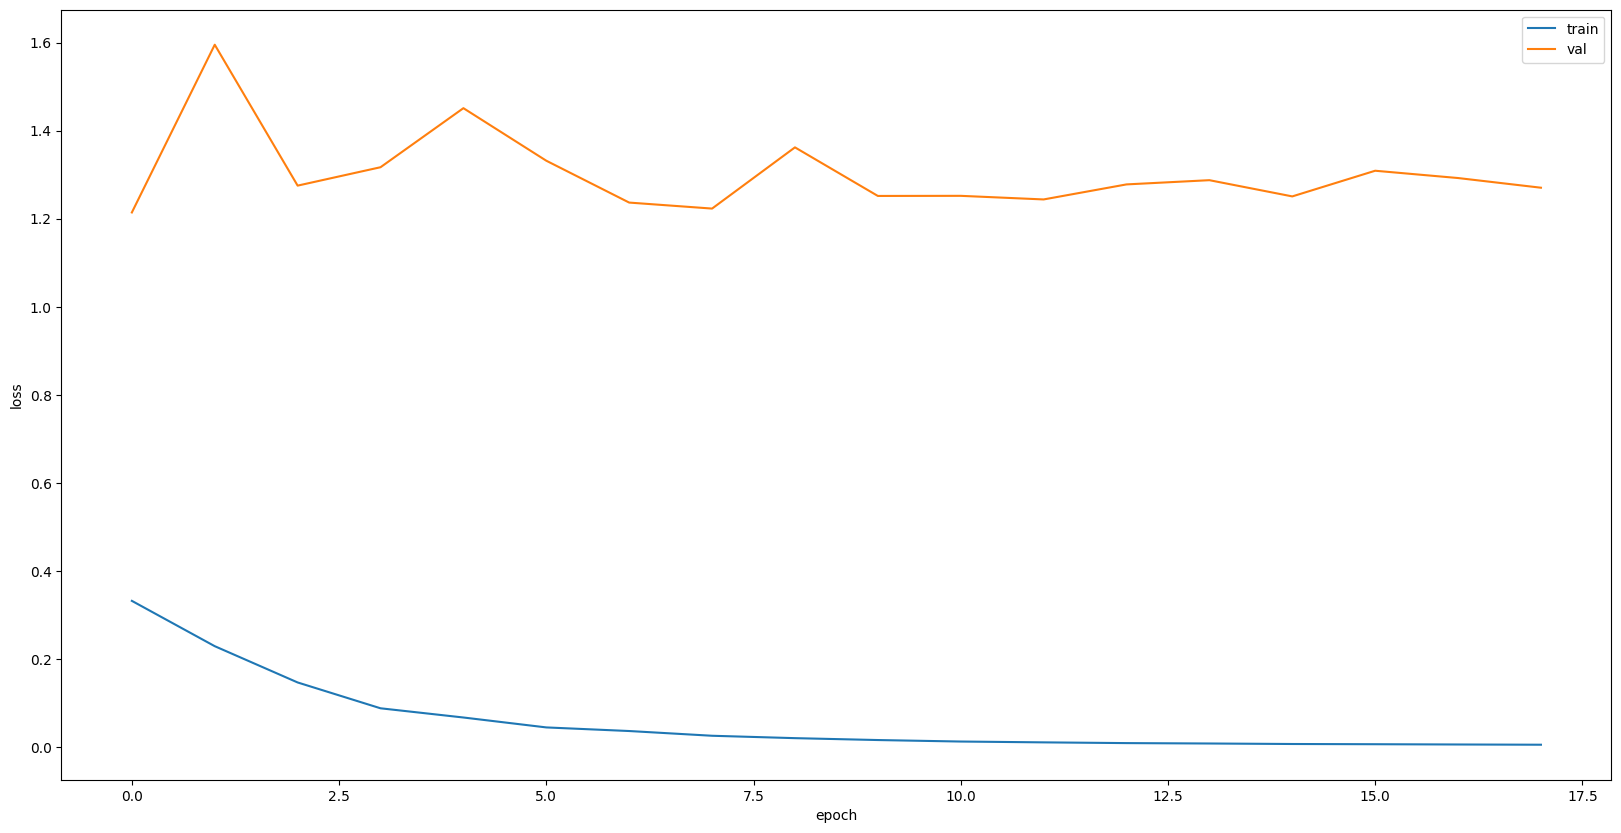

TRAINING SET
Loss: 0.019281921908259392 
Accuracy: 1.0

VALIDATION SET
Loss: 1.2229365110397339 
Accuracy: 0.7916666865348816

TEST SET
Loss: 0.31946665048599243 
Accuracy: 0.887499988079071
3/3 [==============================] - 0s 4ms/step


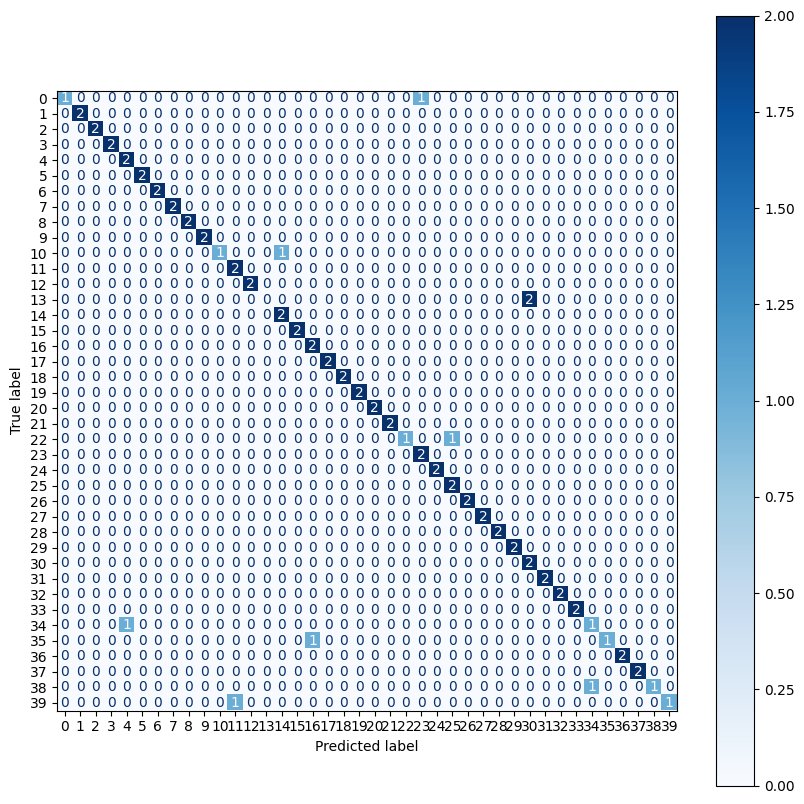

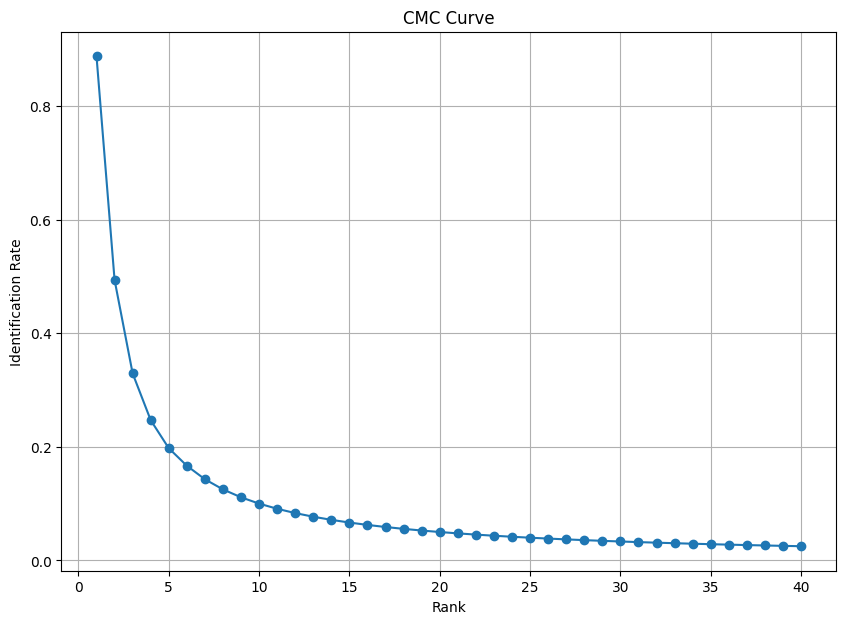

In [20]:
# training with augmentation
training_model_with_augmentation(x_train, y_train, x_test, y_test, x_val, y_val, augmentation, model)

# Compare results with LeNet5


### Scenario 1


#### Accuracy

1. K -NN : 73%
2. PCA: 72% (50 eigenvectors)
3. LDA: 73%
4. SVM: 76%


| Models  | Accuracy (without data augmentation) | Accuracy (with data augmentation) | Hyperparameters                                             |
| ------- | ------------------------------------ | --------------------------------- | ----------------------------------------------------------- |
| K-NN    | 73%                                  | 75%                               | k = 1                                                       |
| PCA     | 72%                                  | 72%                               | 50 eigenvectors                                             |
| LDA     | 73%                                  | 73%                               | n = 1                                                       |
| SVM     | 76%                                  | 76%                               | 'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear' |
| LeNet 5 | 2%                                   | 3%                                |


### Scenario 2


#### Accuracy

1. K -NN : 88%
2. PCA: 88% (50 eigenvectors)
3. LDA: 90%
4. SVM: 90%


| Models  | Accuracy (without data augmentation) | Accuracy (with data augmentation) | Hyperparameters                                             |
| ------- | ------------------------------------ | --------------------------------- | ----------------------------------------------------------- |
| K-NN    | 85%                                  | 88%                               | k = 1                                                       |
| PCA     | 88%                                  | 88%                               | 50 eigenvectors                                             |
| LDA     | 90%                                  | 90%                               | n = 1                                                       |
| SVM     | 90%                                  | 90%                               | 'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear' |
| LeNet 5 | 72%                                  | 77%                               |


### Scenario 3


#### Accuracy

1. K -NN : 89%
2. PCA: 89% (50 eigenvectors)
3. LDA: 97%
4. SVM: 95%


| Models  | Accuracy (without data augmentation) | Accuracy (with data augmentation) | Hyperparameters |
| ------- | ------------------------------------ | --------------------------------- | --------------- |
| K-NN    | 85%                                  | 89%                               | k = 1           |
| PCA     | 89%                                  | 89%                               | 50 eigenvectors |
| LDA     | 97%                                  | 97%                               | n = 1           |
| SVM     | 95%                                  | 95%                               | C = 1           |
| LeNet 5 | 87.5%                                | 88%                               |


### Notes

- On cmc curve, the identification rates are highest at lowest rank mean that the model only need to train on a few epochs to achieve best accuracy. We conclude that the dataset is simple because model does not need to learn too much
